# Convolutional Neural Network - Face Recognition

Face recognition problems commonly fall into two categories: 

- **Face Verification** - "is this the claimed person?". For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem. 

- **Face Recognition** - "who is this person?". For example, employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem. 

# FaceNet

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.
    
**Face Recognition Requires:**
- Implement the triplet loss function
- Use a pretrained model to map face images into 128-dimensional encodings
- Use these encodings to perform face verification and face recognition

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K

import matplotlib.pyplot as plt

import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf


import sys
import h5py


Using TensorFlow backend.


## Channels First Convention

This program is using a pre-trained model which represents ConvNet activations using a "channels first" convention, as opposed to the "channels last" convention used in lecture and previous programming assignments. In other words, a batch of images will be of shape $(m, n_C, n_H, n_W)$ instead of $(m, n_H, n_W, n_C)$. Both of these conventions have a reasonable amount of traction among open-source implementations; there isn't a uniform standard yet within the deep learning community. 

In [2]:
np.set_printoptions(threshold=sys.maxsize)
K.set_image_data_format('channels_first')
#np.set_printoptions(threshold=np.nan)

## Naive Face Verification

In Face Verification, you're given two images and you have to tell if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images are less than a chosen threshold, it may be the same person! 

Of course, this algorithm performs really poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, even minor changes in head position, and so on. 



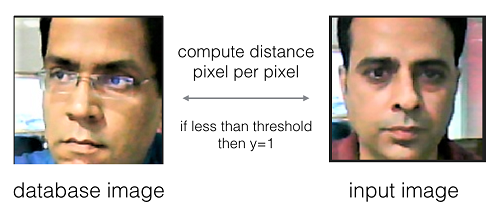

## Encoding face images into a 128-dimensional vector 
 Rather than using the raw image, you can learn an encoding $f(img)$ so that element-wise comparisons of this encoding gives more accurate judgements as to whether two pictures are of the same person.

### Using an ConvNet  to compute encodings

The FaceNet model takes a lot of data and a long time to train. So following common practice in applied deep learning settings, let's just load weights that someone else has already trained. The network architecture follows the Inception model.


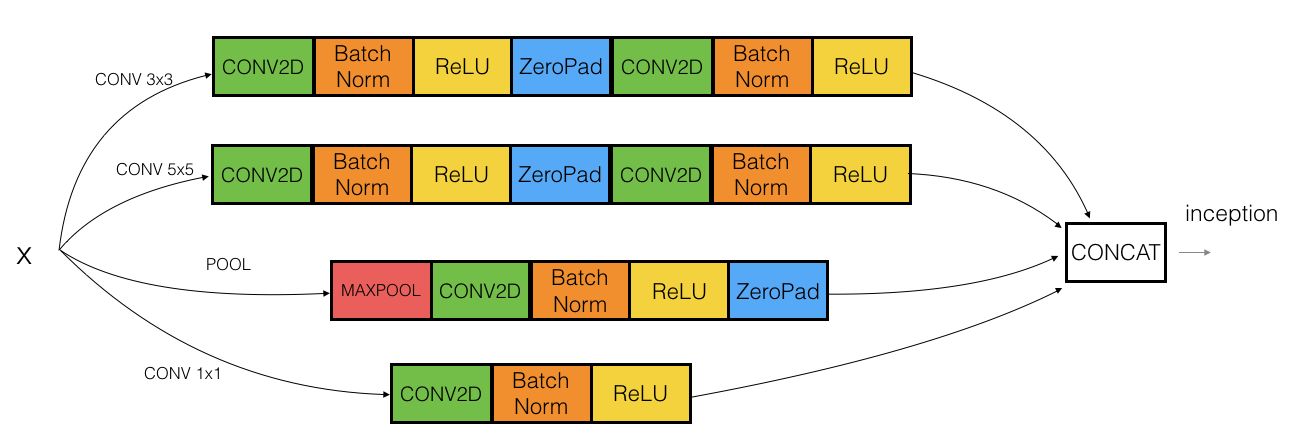

The key things you need to know are:

- This network uses 96x96 dimensional RGB images as its input. Specifically, inputs a face image (or batch of $m$ face images) as a tensor of shape $(m, n_C, n_H, n_W) = (m, 3, 96, 96)$ 
- It outputs a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. You then use the encodings the compare two face images as follows:
 By computing a distance between two encodings and thresholding, you can determine if the two pictures represent the same person

So, an encoding is a good one if: 
- The encodings of two images of the same person are quite similar to each other 
- The encodings of two images of different persons are very different

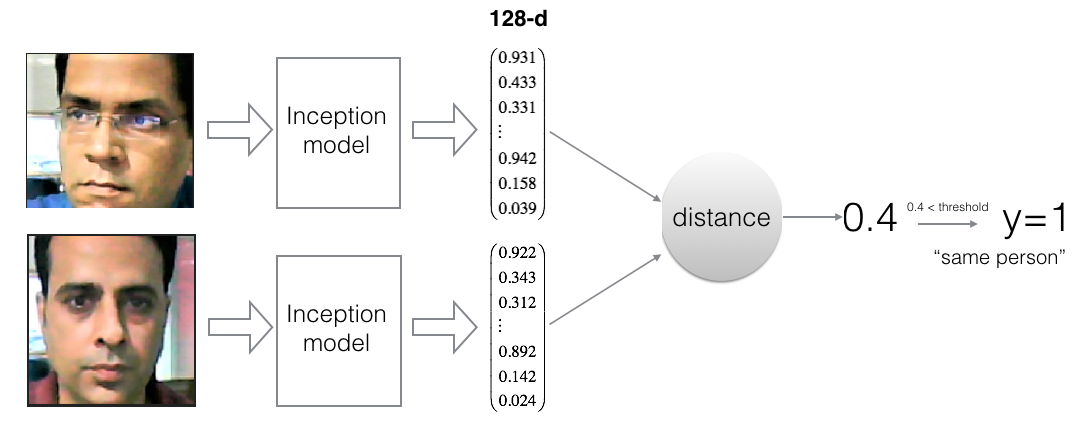

# Helper Function

In [3]:
def variable(value, dtype='float32', name=None):
    v = tf.Variable(np.asarray(value, dtype=dtype), name=name)
    _get_session().run(v.initializer)
    return v

def shape(x):
    return x.get_shape()

def square(x):
    return tf.square(x)

def zeros(shape, dtype='float32', name=None):
    return variable(np.zeros(shape), dtype, name)

def vconcatenate(tensors, axis=-1):
    if axis < 0:
        axis = axis % len(tensors[0].get_shape())
    return tf.concat(axis, tensors)

def LRN2D(x):
    return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(x,layer=None,cv1_out=None, cv1_filter=(1, 1),cv1_strides=(1, 1),
              cv2_out=None,cv2_filter=(3, 3),cv2_strides=(1, 1), padding=None):
    
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_first', name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding, data_format='channels_first')(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_first', name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor



def load_weights_from_FaceNet(FRmodel,dirPath):
    # Load weights from csv files (which was exported from Openface torch model)
    weights = WEIGHTS
    weights_dict = load_weights(dirPath)

    # Set layer weights of the model
    for name in weights:
        if FRmodel.get_layer(name) != None:
            FRmodel.get_layer(name).set_weights(weights_dict[name])
        elif model.get_layer(name) != None:
            model.get_layer(name).set_weights(weights_dict[name])

def load_weights(dirPath):
    fileNames = filter(lambda f: not f.startswith('.'), os.listdir(dirPath))
    paths = {}
    weights_dict = {}

    for n in fileNames:
        paths[n.replace('.csv', '')] = dirPath + '/' + n

    for name in WEIGHTS:
        if 'conv' in name:
            conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            conv_w = np.reshape(conv_w, conv_shape[name])
            conv_w = np.transpose(conv_w, (2, 3, 1, 0))
            conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            weights_dict[name] = [conv_w, conv_b]     
        elif 'bn' in name:
            bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
            bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
            weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
        elif 'dense' in name:
            dense_w = genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
            dense_w = np.reshape(dense_w, (128, 736))
            dense_w = np.transpose(dense_w, (1, 0))
            dense_b = genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
            weights_dict[name] = [dense_w, dense_b]

    return weights_dict

In [4]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
def img_path_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)
    return img_to_encoding(img1, model)


def DisplayImage(imgFileName,style="inline"):
    winName='Image'
    img = cv2.imread(imgFileName)
    img = cv2.resize(img, dsize=(800,500))
    if(style.lower()=="popup"):
        while True:
            cv2.imshow(winName, img)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            if cv2.getWindowProperty(winName,1) == -1 :
                break
        cv2.destroyAllWindows()
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.axis('off')
        plt.imshow(img)
        

def img_to_encoding(image, model):
    image = cv2.resize(image, (96, 96)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding

# Create the model for face images.

In [6]:

def inception_block_1a(X):
    """
    Implementation of an inception block
    """
    
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name ='inception_3a_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name = 'inception_3a_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3a_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    
    X_5x5 = Conv2D(16, (1, 1), data_format='channels_first', name='inception_3a_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(32, (5, 5), data_format='channels_first', name='inception_3a_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3a_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=((3, 4), (3, 4)), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3a_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)
        
    # CONCAT
    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_1b(X):
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name='inception_3b_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3b_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)

    X_5x5 = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3b_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(64, (5, 5), data_format='channels_first', name='inception_3b_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=(4, 4), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)

    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_1c(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_3c_3x3',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))

    X_5x5 = conv2d_bn(X,
                           layer='inception_3c_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)

    return inception

def inception_block_2a(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_4a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=192,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_5x5 = conv2d_bn(X,
                           layer='inception_4a_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(1, 1),
                           padding=(2, 2))

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_4a_pool',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           padding=(2, 2))
    X_1x1 = conv2d_bn(X,
                           layer='inception_4a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_2b(X):
    #inception4e
    X_3x3 = conv2d_bn(X,
                           layer='inception_4e_3x3',
                           cv1_out=160,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))
    X_5x5 = conv2d_bn(X,
                           layer='inception_4e_5x5',
                           cv1_out=64,
                           cv1_filter=(1, 1),
                           cv2_out=128,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))
    
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)

    return inception

def inception_block_3a(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_5a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5a_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           padding=(1, 1))
    X_1x1 = conv2d_bn(X,
                           layer='inception_5a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))

    inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)

    return inception

def inception_block_3b(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_5b_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5b_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1))
    X_pool = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_pool)

    X_1x1 = conv2d_bn(X,
                           layer='inception_5b_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)

    return inception

In [7]:

def faceRecoModel(input_shape):
        
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)
    
    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)

    # Second Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    # Inception 1: a/b/c
    X = inception_block_1a(X)
    X = inception_block_1b(X)
    X = inception_block_1c(X)
    
    # Inception 2: a/b
    X = inception_block_2a(X)
    X = inception_block_2b(X)
    
    # Inception 3: a/b
    X = inception_block_3a(X)
    X = inception_block_3b(X)
    
    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_first')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)
    
    # L2 normalization
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='FaceRecoModel')
        
    return model

In [8]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


### The Triplet Loss

For an image $x$, we denote its encoding $f(x)$, where $f$ is the function computed by the neural network.

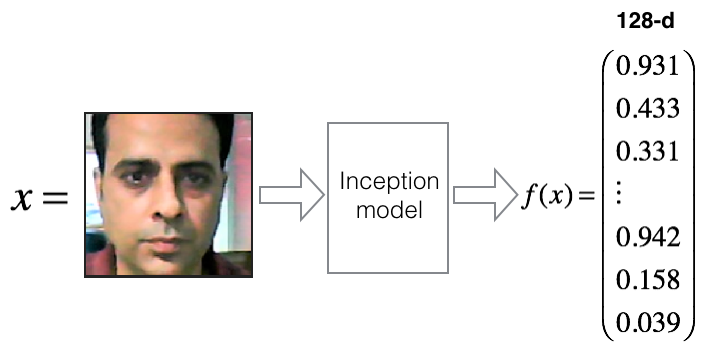

<!--
We will also add a normalization step at the end of our model so that $\mid \mid f(x) \mid \mid_2 = 1$ (means the vector of encoding should be of norm 1).
!-->

Training will use triplets of images $(A, P, N)$:  


Pictures from left to right:Anchor (A), Positive (P), Negative (N) 

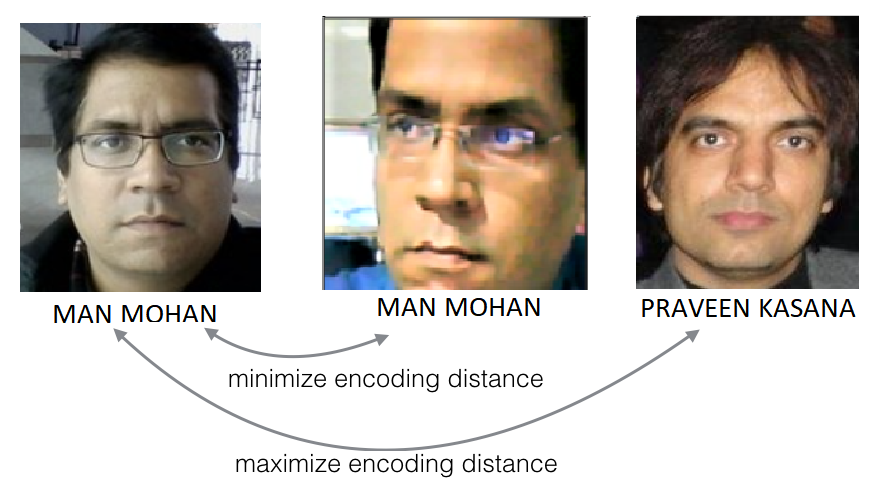

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart. 

- A is an "Anchor" image--a picture of a person. 
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example. 

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 + \alpha < \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$$

You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{N}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$

Here, we are using the notation "$[z]_+$" to denote $max(z,0)$.  

Notes:
- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; you want this to be small. 
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, you want this to be relatively large, so it thus makes sense to have a minus sign preceding it. 
- $\alpha$ is called the margin. It is a hyperparameter that you should pick manually. We will use $\alpha = 0.2$. 

Most implementations also normalize the encoding vectors  to have norm equal one (i.e., $\mid \mid f(img)\mid \mid_2$=1); you won't have to worry about that here.

**Implementing the triplet loss**  
As defined by formula (3). Here are the 4 steps:
1. Compute the distance between the encodings of "anchor" and "positive": $\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$
2. Compute the distance between the encodings of "anchor" and "negative": $\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$
3. Compute the formula per training example: $ \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2 + \alpha$
3. Compute the full formula by taking the max with zero and summing over the training examples:
$$\mathcal{J} = \sum^{N}_{i=1} \large[ \small \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2+ \alpha \large ] \small_+ \tag{3}$$

Useful functions: `tf.reduce_sum()`, `tf.square()`, `tf.subtract()`, `tf.add()`, `tf.reduce_mean`, `tf.maximum()`.


"""
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """

In [10]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)))
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)))
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.maximum(tf.reduce_mean(basic_loss), 0.0)
     
    return loss

In [11]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))

loss = 350.02716


**Expected Output**:

<table>
    <tr>
        <td>
            **loss**
        </td>
        <td>
           350.026
        </td>
    </tr>

</table>

## Loading the trained model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, we won't train it from scratch here. Instead, we load a previously trained model. Load a model using the following cell; this might take a couple of minutes to run. 

In [12]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

In [13]:
WEIGHTS = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]

conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}


In [14]:
load_weights_from_FaceNet(FRmodel,"../input/FaceDS/FaceNet_Weights")

In [15]:
FRmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 3, 102, 102)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 48, 48)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 64, 48, 48)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [20]:
# Path for positive and anchor images
paths = {'person1' : "../input/FaceDS/manmohan/",
        'person2' : "../input/FaceDS/pawan/"}
faces = ['manmohan', 'pawan']


negPath = '../input/FaceDS/kasana/' # Path of negative images
negImages = []


images = []
for key in paths.keys():
    li = []
    for img in os.listdir(paths[key]):
        img1 = cv2.imread(paths[key]+img)
        img2 = img1[...,::-1]
        li.append(np.around(np.transpose(img2, (2,0,1))/255.0, decimals=12))
    images.append(li)

for img in os.listdir(negPath):
    img1 = cv2.imread(negPath+img)
    img2 = img1[...,::-1]
    negImages.append(np.around(np.transpose(img2, (2,0,1))/255.0, decimals=12))
    

for i in range(len(images)):
    images[i] = np.array(images[i])
negImages = np.array(negImages)


# Generator with random person as positive and anchor. negImages as negative images.
def batch_generator(batch_size = 64):
    while True:
        a= np.random.randint(0, len(images), 1)
        pos = images[a[0]][np.random.choice(len(images[a[0]]), batch_size)]
        neg = negImages[np.random.choice(len(negImages), batch_size)]
        anc = images[a[0]][np.random.choice(len(images[a[0]]), batch_size)]

        x_data = {'anchorMain': anc,
                  'anchorPositive': pos,
                  'anchorNegative': neg
                  }
        
        yield (x_data, np.zeros((batch_size, 2, 1)))
        

# Generator with randomly selected person as positive and anchor. Other randomly selected person as negative examples.
# Model will learn to differentiate between persons to be recognized.
def batch_generator2(batch_size = 64):
    while True:
        a= np.random.randint(0, len(images), 1)
        b= np.random.randint(0, len(images), 1)
        while b==a:
            b= np.random.randint(0, len(images), 1)
            
        pos = images[a[0]][np.random.choice(len(images[a[0]]), batch_size)]
        neg = images[b[0]][np.random.choice(len(images[b[0]]), batch_size)]
        anc = images[a[0]][np.random.choice(len(images[a[0]]), batch_size)]

        x_data = {'anchorMain': anc,
                  'anchorPositive': pos,
                  'anchorNegative': neg
                  }
        
        yield (x_data, np.zeros((batch_size, 2, 1)))

In [17]:
# Triplet loss function
def triplet_loss_v2(y_true, y_pred):
    positive, negative = y_pred[:,0,0], y_pred[:,1,0]
    margin = K.constant(0.35)
    loss = K.mean(K.maximum(K.constant(0), positive - negative + margin))
    return loss

def euclidean_distance(vects):
    x, y = vects
    dist = K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))
    return dist

In [18]:
# Model Structure
input_shape=(3, 96, 96)
anchorMain = Input(shape=input_shape, name = 'anchorMain')
anchorPositive = Input(shape=input_shape, name = 'anchorPositive')
anchorNegative = Input(shape=input_shape, name = 'anchorNegative')

anchorMainCode = FRmodel(anchorMain)
anchorPosCode = FRmodel(anchorPositive)
anchorNegCode = FRmodel(anchorNegative)


positive_dist = Lambda(euclidean_distance, name='pos_dist')([anchorMainCode, anchorPosCode])
negative_dist = Lambda(euclidean_distance, name='neg_dist')([anchorMainCode, anchorNegCode])
stacked_dists = Lambda(lambda vects: K.stack(vects, axis=1), name='stacked_dists')([positive_dist, negative_dist])





# Model
tripletModel = Model([anchorMain, anchorPositive, anchorNegative], stacked_dists, name='triple_siamese')
tripletModel.compile(optimizer = 'adadelta', loss = triplet_loss_v2, metrics = ['accuracy'])

In [21]:
# Setting layers non-trainable
for layer in FRmodel.layers[0: 100]:
    layer.trainable  =  False
    
gen = batch_generator(64)
tripletModel.fit_generator(gen, epochs=1,steps_per_epoch=3)

gen = batch_generator2(64)
tripletModel.fit_generator(gen, epochs=1,steps_per_epoch=3)
tripletModel.summary()

Epoch 1/1


ValueError: Error when checking input: expected anchorNegative to have shape (3, 96, 96) but got array with shape (3, 150, 130)

In [ ]:
# Freezing more layers
for layer in FRmodel.layers[0: 130]:
    layer.trainable  =  False
early_stopping = EarlyStopping(monitor='loss', patience=2, min_delta=0.0000001)

gen = batch_generator(64)
tripletModel.compile(optimizer = 'adadelta', loss = triplet_loss_v2, metrics = ['accuracy'])
tripletModel.fit_generator(gen, epochs=10,steps_per_epoch=30,callbacks=[early_stopping, tensorboard])

gen = batch_generator2(64)
tripletModel.fit_generator(gen, epochs=10,steps_per_epoch=30,callbacks=[early_stopping, tensorboard])
tripletModel.summary()

FRmodel.save("../input/FaceDS/FRmodel.h5")

## Distance between Encodings

In [15]:
encManmohan1=img_path_to_encoding("../input/FaceDS/manmohan1.jpg", FRmodel)
encPawan1=img_path_to_encoding("../input/FaceDS/pawan1.jpg", FRmodel)
dist1 = np.linalg.norm(encManmohan1-encPawan1)
print("Distance ManMohan and Pawan =",dist1)

Distance ManMohan and Pawan = 0.6670825


In [16]:
encManmohan2=img_path_to_encoding("../input/FaceDS/manmohan2.jpg", FRmodel)
encPawan2=img_path_to_encoding("../input/FaceDS/pawan2.jpg", FRmodel)
dist2 = np.linalg.norm(encManmohan2-encPawan2)
print("Distance ManMohan and Pawan =",dist2)

Distance ManMohan and Pawan = 0.7757705


In [17]:
dist1 = np.linalg.norm(encManmohan1-encManmohan2)
print("Distance ManMohan1 and ManMohan2 =",dist1)

Distance ManMohan1 and ManMohan2 = 0.20532842


In [18]:
dist1 = np.linalg.norm(encPawan1-encPawan2)
print("Distance Pawan1 and Pawan2 =",dist1)

Distance Pawan1 and Pawan2 = 0.2486705


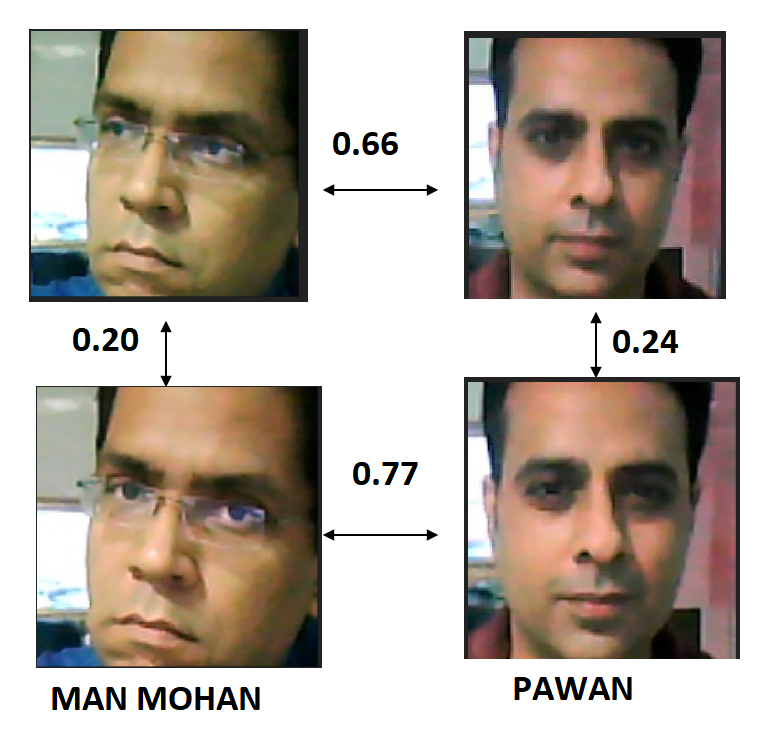


## Applying the model

Back to the Happy House! Residents are living blissfully since you implemented happiness recognition for the house in an earlier assignment.  

However, several issues keep coming up: The Happy House became so happy that every happy person in the neighborhood is coming to hang out in your living room. It is getting really crowded, which is having a negative impact on the residents of the house. All these random happy people are also eating all your food. 

So, you decide to change the door entry policy, and not just let random happy people enter anymore, even if they are happy! Instead, you'd like to build a **Face verification** system so as to only let people from a specified list come in. To get admitted, each person has to swipe an ID card (identification card) to identify themselves at the door. The face recognition system then checks that they are who they claim to be. 

# Face Verification

Let's build a database containing one encoding vector for each person allowed to enter the happy house. To generate the encoding we use `img_to_encoding(image_path, model)` which basically runs the forward propagation of the model on the specified image. 

Run the following code to build the database (represented as a python dictionary). This database maps each person's name to a 128-dimensional encoding of their face.

In [19]:
database = {}
database["manmohan"] = img_path_to_encoding("../input/FaceDS/manmohan1.jpg", FRmodel)
database["pawan"] = img_path_to_encoding("../input/FaceDS/pawan1.jpg", FRmodel)
database["kasana"] = img_path_to_encoding("../input/FaceDS/praveenkasana.jpg", FRmodel)

### Analyze Other Images in Folder

In [20]:
import glob
FolderPath="../input/FaceDS/pawan"
imgIndex=0
imgList=glob.glob(FolderPath+"/*.jpg")

encManmohan1=img_path_to_encoding("../input/FaceDS/manmohan1.jpg", FRmodel)
dist_min=100
dist_max=-100
for imgIndex in range(len(imgList)) :
    inputFileName=imgList[imgIndex]
    encManmohan2=img_path_to_encoding(inputFileName, FRmodel)
    dist = np.linalg.norm(encManmohan2-encManmohan1)
    
    
    if dist<dist_min:
        dist_min=dist
    if dist>dist_max:
        dist_max=dist
print("min=",dist_min,"max=",dist_max)

min= 0.43923318 max= 1.0315286


Now, when someone shows up at your front door and swipes their ID card (thus giving you their name), you can look up their encoding in the database, and use it to check if the person standing at the front door matches the name on the ID.

To checks if the front-door camera picture (`image_path`) is actually the person called "identity". You will have to go through the following steps:
1. Compute the encoding of the image from image_path
2. Compute the distance about this encoding and the encoding of the identity image stored in the database
3. Open the door if the distance is less than 0.7, else do not open.

As presented above, you should use the L2 distance (np.linalg.norm). (Note: In this implementation, compare the L2 distance, not the square of the L2 distance, to the threshold 0.7.) 

"""
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be a resident of the Happy house.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """

In [21]:
def verify(image_path, identity, database, model):
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = img_path_to_encoding(image_path, model)
    
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding-database[identity])
    
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist < 0.6:
        print("It's " + str(identity) + ", welcome home!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
    print("Distance=",dist,"Door Opened=", door_open)
    
    return 

# Test 
ManMohan is trying to enter the Happy House and the camera takes a picture of him. Let's run your verification algorithm on this picture:


It's pawan, welcome home!
Distance= 0.0 Door Opened= True


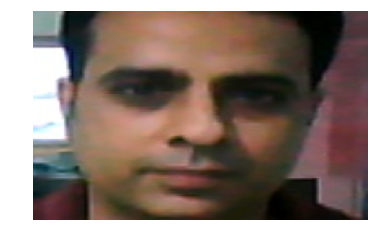

In [22]:
IDCardName="pawan"
imgFileName="../input/FaceDS/pawan1.jpg"
DisplayImage(imgFileName,style="inline")
verify(imgFileName, IDCardName, database, FRmodel)

Kasana, who broke the aquarium last weekend, has been banned from the house and removed from the database. He stole Pawan's ID card and came back to the house to try to present himself as Pawan. The front-door camera took a picture of Kasana . Let's run the verification algorithm to check if Kasana can enter.

It's not pawan, please go away
Distance= 0.7888563 Door Opened= False


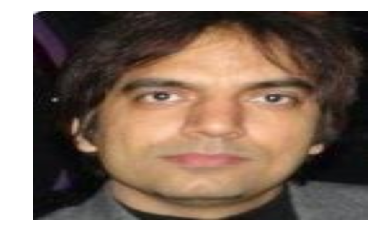

In [23]:
IDCardName="pawan"
imgFileName="../input/FaceDS/praveenkasana.jpg"
DisplayImage(imgFileName,style="inline")
verify(imgFileName, IDCardName, database, FRmodel)

# Face Recognition

Your face verification system is mostly working well. But since Pawan got his ID card stolen, when he came back to the house that evening he couldn't get in! 

To reduce such shenanigans, you'd like to change your face verification system to a face recognition system. This way, no one has to carry an ID card anymore. An authorized person can just walk up to the house, and the front door will unlock for them! 

A face recognition system that takes as input an image, and figures out if it is one of the authorized persons (and if so, who). Unlike the previous face verification system, we will no longer get a person's name as another input. 

Steps to implement `who_is_it()`:
1. Compute the target encoding of the image from image_path
2. Find the encoding from the database that has smallest distance with the target encoding. 
    - Initialize the `min_dist` variable to a large enough number (100). It will help you keep track of what is the closest encoding to the input's encoding.
    - Loop over the database dictionary's names and encodings. To loop use `for (name, db_enc) in database.items()`.
        - Compute L2 distance between the target "encoding" and the current "encoding" from the database.
        - If this distance is less than the min_dist, then set min_dist to dist, and identity to name.
        


In [28]:
def who_is_it(image, database, model):
    
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    if(type(image).__name__=="str"):
        encoding = img_path_to_encoding(image, model)
    else:
        encoding = img_to_encoding(image, model)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100 
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current "emb" from the database. (≈ 1 line)
        dist = np.linalg.norm(encoding-db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name

    
    if min_dist > 0.55:
        identity="Not in the database."
    else:
        identity=str(identity)
        
        
    return identity,min_dist

# Test
Pawan is at the front-door and the camera takes a picture of him. Let's see if your who_it_is() algorithm identifies Pawan. 

It's pawan, the distance is 0.2486705


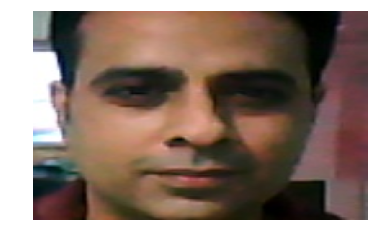

In [25]:
imgFileName="../input/FaceDS/pawan2.jpg"
DisplayImage(imgFileName,style="inline")
identity,dist=who_is_it(imgFileName, database, FRmodel)
print ("It's " + str(identity) + ", the distance is " + str(dist))

Your Happy House is running well. It only lets in authorized persons, and people don't need to carry an ID card around anymore! 

Some ways to further improve the algorithm:
- Put more images of each person (under different lighting conditions, taken on different days, etc.) into the database. Then given a new image, compare the new face to multiple pictures of the person. This would increase accuracy.
- Crop the images to just contain the face, and less of the "border" region around the face. This preprocessing removes some of the irrelevant pixels around the face, and also makes the algorithm more robust.


**What you should remember**:
- Face verification solves an easier 1:1 matching problem; face recognition addresses a harder 1:K matching problem. 
- The triplet loss is an effective loss function for training a neural network to learn an encoding of a face image.
- The same encoding can be used for verification and recognition. Measuring distances between two images' encodings allows you to determine whether they are pictures of the same person. 

# Real Time Camera Prediction

In [29]:
winName='Live Camera'
faceCascade = cv2.CascadeClassifier('../input/FaceDS/haarcascade_frontalface_default.xml')





video_capture = cv2.VideoCapture(0)
count = 0
while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    frame = cv2.flip( frame, 1 ) 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(100, 100))


    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        count = count+1
        x0,y0=int(x),int(y)
        x1,y1=int(x+w),int(y+h)
        roi=frame[y0:y1,x0:x1]#crop 

       

        cropped=cv2.resize(roi, dsize=(96,96))
        identity,dist=who_is_it(cropped, database, FRmodel)
        txt=identity+"(%4.2f)" %dist
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame,txt, (x,y), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0))
       
        
       
    # Display the resulting frame
    cv2.imshow(winName, frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if cv2.getWindowProperty(winName,1) == -1 :
        break
# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()


In [27]:

video_capture.release()
cv2.destroyAllWindows()
